# Logistic Regressions

In [1]:
# WARNING: EXPENSIVE COMPUTING IF RUN_CALCULATION = True
# Calculation has already been done and saved in FILEPATH file and are reloaded from the file in this notebook
RUN_CALCULATION = False
GRID_FILEPATH  = 'saved_grid_search_results/logistic_regression_grid.npy'
PROBS_FILEPATH = 'saved_grid_search_results/logistic_regression_probs.npy'
MODEL_FILEPATH = 'saved_best_models/logistic_regression_model.npy'

In [2]:
# Import functions used in the different notebooks of the course project
%run Tools.ipynb

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import datetime

## Load & Split Train/Test Sets

In [4]:
# Load the overfeat dataset
overfeat, pixels, labels, names = load_data()

# Check shapes
print('Overfeat shape:', overfeat.shape)
print('Pixels shape:', pixels.shape)
print('Labels shape:', labels.shape)

Overfeat shape: (5000, 4096)
Pixels shape: (5000, 3072)
Labels shape: (5000,)


In [5]:
# Split the train/test sets (4000/1000 stratified split)
X_train, X_test, y_train, y_test = split_data_stratified(overfeat, labels)
print('Train shape:', X_train.shape, y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)

# Check the classes distribution in the test set
print('\nTest Classes Distribution:')
pd.value_counts(names[y_test])

Train shape: (4000, 4096) (4000,)
Test shape: (1000, 4096) (1000,)

Test Classes Distribution:


airplane    250
car         250
truck       250
ship        250
dtype: int64

## Logistic Regression Classifier

We will create a logistic regression classifier with stochastic gradient descent learning. So, we will use the `SGDClassifier` model and its `log` loss function that results to a probabilistic classifier. We will tune its regularization strenght (alpha) and the number of PCA components when PCA is applied as a pre-processing step.

What is logistic regression, what results to expect and their meanings ? Logistic regression is a probabilistic classifier that gives the probabilities than a test point belongs to one class or the other (in its binary classifier configuration). Because we are working with four outcome classes and `SGDClassifier` implements the One VS Others strategy, we will have behind the scene one binary classifier for each class. A test point will be evaluated on each sub-classifier, each one giving the probability that it belongs to the class it models. The test point predicted class is the one with the highest probability.

A binary classifier could be built by encoding the class and all other classes as a dummy variable and by fitting a linear regression between the features and this dummy variable. However, we would have to deal with negative and greater than one probabilities. So, instead of relating probabilities to a linear function in the features space, logistic regression use a logistic function (sigmoid curve), a strongly non-linear function that guarantee that the probabilities remains in the [0, 1] range. How this probabilistic function relates to the features ? In fact, by the way the logistic model is expressed, its logit/log-odds is linear in the feature space X.

Who say linear regression, say that a vector of p+1 coefficients has to be learned where p is the number of features. It will be the job of the SGD algorithm to find these coefficients. At the end, the vector of coefficients obtained will be the one that maximize the likelihood function (probabilities close to 1 for points that belongs to the class, probabilities close to 0 for points that don't).

Now, we can go ahead with our grid search with a good understanfing of the hyperparameters:

* By reducing the number of dimensions with PCA, we also reduce the number of coefficients to learn
* By increasing the regularization strength, we shrink the coefficients towards zero and we are diminushing the absolute value of the logit. As a result, probabilities given by each binary sub-classifiers tend to be pulled towards 50%. So the regularizazion strength allow us to manage the bias-variance trade-off: high alpha => high bias/low variance, low alpha => low bias/high variance)

Note that:

* SGD algorithm prefers to work with standardized data, so even when we will not apply PCA, we will standardize the data
* No PCA means 4096 features, so 4097 coefficients to learn but with only 3200 training observations. I don't like this idea but we will do it anyway :)

In [6]:
# Hyperparameters
pca__n_components = [62, 176, 408, 1072]
log__alpha = np.logspace(-6, 2, 50)

# Grid search calculation if not already computed previously or forced
if RUN_CALCULATION | (os.path.exists(GRID_FILEPATH) == False):

    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', None),  
        ('log', SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-3, random_state=0))
    ])

    # Grid Search with Cross-Validation (multi-grid, one without PCA, one with PCA)
    grid_cv = GridSearchCV(
        pipe,
        [
            {
                # grid with no PCA
                'log__alpha': log__alpha
            },
            {
                # grid with PCA
                'pca': [PCA(random_state=0)],
                'pca__n_components': pca__n_components,
                'log__alpha': log__alpha
            }
        ],
        cv=5,  # 5 folds => 3200 train, 800 validation
        verbose=3
    )

    # Fit the model
    grid_cv.fit(X_train, y_train)
    
    # Save results in a numpy file
    np.save(GRID_FILEPATH, grid_cv)
else:
    # Load the grid search results from file
    grid_cv = np.load(GRID_FILEPATH, allow_pickle=True).item(0)

In [7]:
# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('n_components', grid_cv.cv_results_['param_pca__n_components']),
    ('alpha', grid_cv.cv_results_['param_log__alpha']),
    ('mean_training_accuracy', grid_cv.cv_results_['mean_train_score']),
    ('training_standard_deviation', grid_cv.cv_results_['std_train_score']),
    ('mean_validation_accuracy', grid_cv.cv_results_['mean_test_score']),
    ('validation_standard_deviation', grid_cv.cv_results_['std_test_score']),
])

# Replace missing n_components value by the number of features (4096)
df['n_components'].fillna(value=overfeat.shape[1], inplace=True)

# Sort by validation accuracy desc
df.sort_values(by='mean_validation_accuracy', ascending=False).head(20)

,n_components,alpha,mean_training_accuracy,training_standard_deviation,mean_validation_accuracy,validation_standard_deviation
133,1072,0.00184207,0.916438,0.004301,0.84000,0.015104
24,4096,0.00828643,0.907937,0.002352,0.83850,0.013309
129,1072,0.00126486,0.916438,0.003381,0.83800,0.014199
145,1072,0.00568987,0.907312,0.003034,0.83750,0.010954
23,4096,0.00568987,0.910937,0.002227,0.83750,0.013807
124,408,0.000868511,0.896500,0.003609,0.83675,0.011000
15,4096,0.000281177,0.935375,0.003549,0.83625,0.011646
20,4096,0.00184207,0.920437,0.002344,0.83625,0.011646
125,1072,0.000868511,0.922563,0.003077,0.83600,0.012283
10,4096,4.29193e-05,0.952688,0.005164,0.83575,0.015644


Let's plot some curves to have better insigths because there are some sign of overfitting. Alpha can change a lot without a huge impact on the mean validation accuracy. High number of features seems to give better results also.

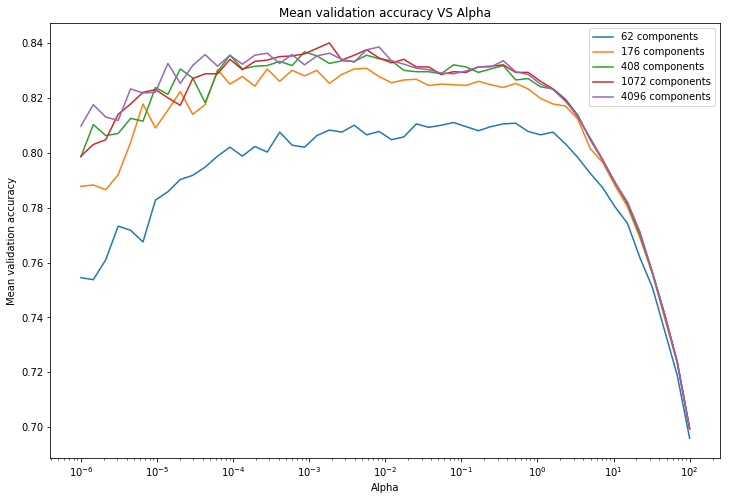

In [8]:
# Plot the mean validation accuracy vs alpha curves for the different values of pca n components
plt.figure(figsize=(12, 8))
for n_components in np.unique(df.n_components):
    filter = (df.n_components == n_components)
    plt.semilogx(df.alpha[filter], df.mean_validation_accuracy[filter], label='{} components'.format(n_components))
    plt.xlabel('Alpha'), 
    plt.ylabel('Mean validation accuracy')
    plt.title('Mean validation accuracy VS Alpha')

plt.legend()
plt.show()

We can see that high number of pca components/features improve the results. The curves without PCA (4096 features) and PCA with 1072 components (99% variance) are similar. So, it makes more sense to apply PCA to reduce the number of features and don't have more coefficients to learn than the number of data points to train the model.

The curves are bumpy for low values of alpha until alpha reach about 0.5. Giving more flexibility (high variance, low bias) to the model don't improve necessarily its validation accuracy and could be a sign of unwanted/useless overfitting. The optimal value seems to live around 0.002 but notice that the validation accuracy doesn't increase monotonically in the alpha range [0.001, 100]. Selecting the model hyperparameters corresponding to the first validation accuracy maximum could be more rational.

These bumbs let's me think that there are probably two kinds of misclassifications: one that will be always misclassified (around 18% of the images), there are just no way to find the good answer in our feature space and some images for which the models have a hard time to figure out if the images belongs to one class or the other. Depending the hyperparameters, it switch from one or another, so the bumps. 

Let's compare the 1072 components validation curve with its training curve...

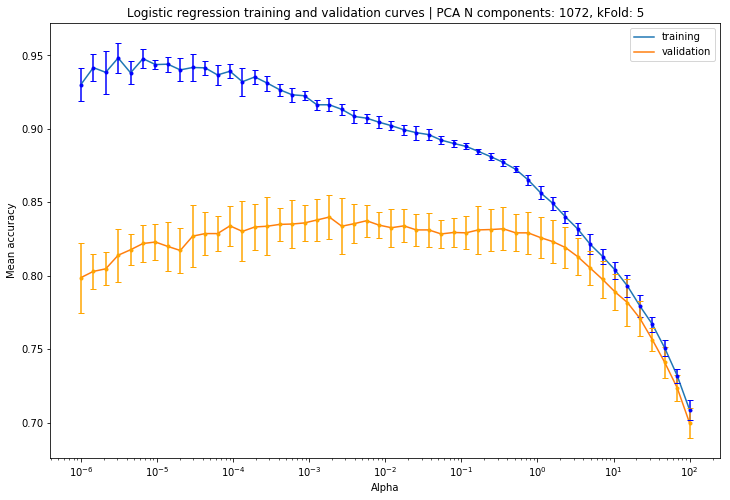

In [9]:
# model with 1072 components (99% variance)
filter = (df.n_components == 1072)

plt.figure(figsize=(12, 8))
plt.semilogx(df.alpha[filter], df.mean_training_accuracy[filter], label='training')
plt.semilogx(df.alpha[filter], df.mean_validation_accuracy[filter], label='validation')
plt.errorbar(df.alpha[filter], df.mean_training_accuracy[filter], df.training_standard_deviation[filter], linestyle='None', marker='.', capsize=3, color='blue', label=None)
plt.errorbar(df.alpha[filter], df.mean_validation_accuracy[filter], df.validation_standard_deviation[filter], linestyle='None', marker='.', capsize=3, color='orange', label=None)
plt.xlabel('Alpha'), 
plt.ylabel('Mean accuracy')
plt.title('Logistic regression training and validation curves | PCA N components: 1072, kFold: 5')

plt.legend()
plt.show()

It confirms that the training accuracy continue to grow as alpha is diminushing but the validation accuracy oscillate around 82-83% before dropping as expected for very low value of alpha. 

### Model Selection  and Accuracy on test set

Here, we will select two models and compare the results just to know:
* The model with the optimal mean validation accuracy returned by our grid search
* The model with 1072 pca components and alpha corresponding to the first validation accuracy maximum

#### Best model according to our grid search

In [10]:
# Model that maximize the mean accuracy
print('Top accuracy across folds: {:.3f} (std: {:.3f}) with {} components and alpha: {:.5f}'.format(
    grid_cv.best_score_,
    grid_cv.cv_results_['std_test_score'][grid_cv.best_index_],
    grid_cv.best_params_['pca__n_components'],
    grid_cv.best_params_['log__alpha']
))

# Accuracy on test set
train_accuracy = grid_cv.score(X_train, y_train)
test_accuracy = grid_cv.score(X_test, y_test)
print('Logistic regression accuracy (train set): {:.3f}'.format(train_accuracy))
print('Logistic regression accuracy (test set): {:.3f}'.format(test_accuracy))

Top accuracy across folds: 0.840 (std: 0.015) with 1072 components and alpha: 0.00184
Logistic regression accuracy (train set): 0.902
Logistic regression accuracy (test set): 0.829


#### Alternative model corresponding to the first validation accuracy maximum 

In [11]:
def select_logreg_first_maximum_accuracy_model(grid, n_components):
    best_model = {}
    best_test_score = 0
    best_alpha = np.Inf
    results = grid.cv_results_
    
    # Only models build with n components
    filter = (results['param_pca__n_components'] == n_components)
    mean_test_scores = results['mean_test_score'][filter]
    alphas = results['param_log__alpha'][filter]
    
    # reverse order (we want the first maximum of the highest alpha => the best less flexible model)
    mean_test_scores = np.flip(mean_test_scores, axis=0)
    alphas = np.flip(alphas, axis=0)
    
    # Find the alpha corresponding to the first validation accuracy maximum
    for i in range(len(mean_test_scores)):
        if mean_test_scores[i] > best_test_score:
            best_test_score = mean_test_scores[i]
            best_alpha = alphas[i]
        else:
            # we have already reached the first maximum, exit the loop
            
            # get the index corresponding to the best alpha model
            idx = np.where(results['param_log__alpha'][filter] == best_alpha)
            
            # return the model (each key)
            for key in results.keys():   
                if key == 'params':
                    continue
                best_model[key] = results[key][filter][idx][0]
            return best_model

In [12]:
# Model with the first validation accuracy maximum
best_model = select_logreg_first_maximum_accuracy_model(grid_cv, n_components=1072)
print('Top accuracy across folds: {:.3f} (std: {:.3f}) with {} components and alpha: {:.5f}'.format(
    best_model['mean_test_score'],
    best_model['std_test_score'],
    best_model['param_pca__n_components'],
    best_model['param_log__alpha'],
))

Top accuracy across folds: 0.829 (std: 0.014) with 1072 components and alpha: 0.75431


In [13]:
# Accuracy on test set
if RUN_CALCULATION | (os.path.exists(MODEL_FILEPATH) == False):

    # Pipeline estimator
    lr_model = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=best_model['param_pca__n_components'], random_state=0)),  
        ('log', SGDClassifier(alpha=best_model['param_log__alpha'], loss='log', penalty='l2', max_iter=1000, tol=1e-3, random_state=0))
    ])
    
    # Fit model
    lr_model.fit(X_train, y_train)

    # Save model in a numpy file
    np.save(MODEL_FILEPATH, lr_model)
else:
    # Load the grid search results from file
    lr_model = np.load(MODEL_FILEPATH, allow_pickle=True).item(0)
    
# Train and test accuracies
train_accuracy = lr_model.score(X_train, y_train)
test_accuracy  = lr_model.score(X_test, y_test)
print('Logistic regression accuracy (train set): {:.3f}'.format(train_accuracy))
print('Logistic regression accuracy (test set): {:.3f}'.format(test_accuracy))

Logistic regression accuracy (train set): 0.856
Logistic regression accuracy (test set): 0.828


Less flexible (higher bias, lower variance), test accuracy as predicted by the validation accuracy, test accuracy more similar to the training accuracy (less overfitting), this model looks definitively better than the 'automatic' one returned by our grid search.

## Probability of each classes for a some test images

In [14]:
# Split the pixels images the same way as the overfeat dataset
_, X_pixels_test, _, y_pixels_test = split_data_stratified(pixels, labels)

In [15]:
# Get the first three images (and their overfeat representations) of each classes
imgs_pixels = np.empty([12, X_pixels_test.shape[1]])
imgs_overfeat = np.empty([12, X_test.shape[1]])

for label in np.unique(labels):
    filter = (y_pixels_test == label)
    start_idx = label * 3
    end_idx = start_idx + 3
    imgs_pixels[start_idx:end_idx, :] = X_pixels_test[filter][0:3]
    imgs_overfeat[start_idx:end_idx, :] = X_test[filter][0:3]

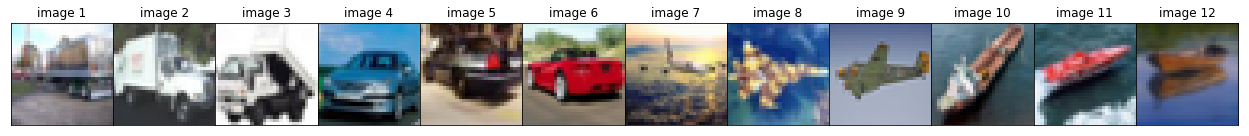

,truck,car,airplane,ship
image 1,0.565,0.012,0.013,0.410
image 2,0.790,0.104,0.016,0.090
image 3,0.806,0.030,0.135,0.029
image 4,0.022,0.268,0.605,0.104
image 5,0.041,0.850,0.088,0.021
image 6,0.203,0.779,0.009,0.008
image 7,0.021,0.003,0.491,0.485
image 8,0.002,0.000,0.614,0.384
image 9,0.124,0.004,0.664,0.207
image 10,0.003,0.003,0.492,0.503


In [16]:
# Plot images
fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(22, 2))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs_pixels[i].reshape(32, 32, 3)/255)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(title='image {}'.format(i+1))
    
plt.subplots_adjust(wspace=0, hspace=0)    
plt.show()

# Compute the probability of each class for each images
probs = np.round(lr_model.predict_proba(imgs_overfeat), 3)

# Build a dataframe to collect the probabilities
df = pd.DataFrame.from_items([
    (names[0], probs[:, 0]),
    (names[1], probs[:, 1]),
    (names[2], probs[:, 2]),
    (names[3], probs[:, 3]),
])
df.index = ['image {}'.format(i+1) for i in range(probs.shape[0])]
df

We don't have all 0 and 1 probabilities that is a good thing and a sign that our model has not overfit too much the training data. A model that would classify images systematically with near 100% confidence would be suspicious. 

For some images (e.g images 2,3,5, 11), our classifier predicts the good classes with high confidence probabilities. However, for some images (e.g images 1, 7, 10), our model predicts the good class but with very few confidence, hesitating between two classes. Note that the image 4 is totally misclassified and it is easy to understand why this blue car and blue sky has been seen as a plane. The image 12 is also misclassified and again probably because of the huge part of blue in the picture.

### Probabilities VS Regularization Strength

In [17]:
# Fit a model for each alpha and compute the probabilities
alphas = log__alpha[log__alpha > 1e-3]
if RUN_CALCULATION | (os.path.exists(PROBS_FILEPATH) == False):
    probs = np.empty([len(alphas), 12, 4])
    
    for i, alpha in enumerate(alphas):
        # Pipeline
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=best_model['param_pca__n_components'], random_state=0)),  
            ('log', SGDClassifier(alpha=alpha, loss='log', penalty='l2', max_iter=1000, tol=1e-3, random_state=0))
        ])
        
        # Fit the model
        pipe.fit(X_train, y_train)
        
        # Compute the probabilities and store them in an array
        probs[i, :, :] = pipe.predict_proba(imgs_overfeat)
        
    # Save results in a numpy file
    np.save(PROBS_FILEPATH, probs)
else:
    # Load the grid search results from file
    probs = np.load(PROBS_FILEPATH, allow_pickle=True)

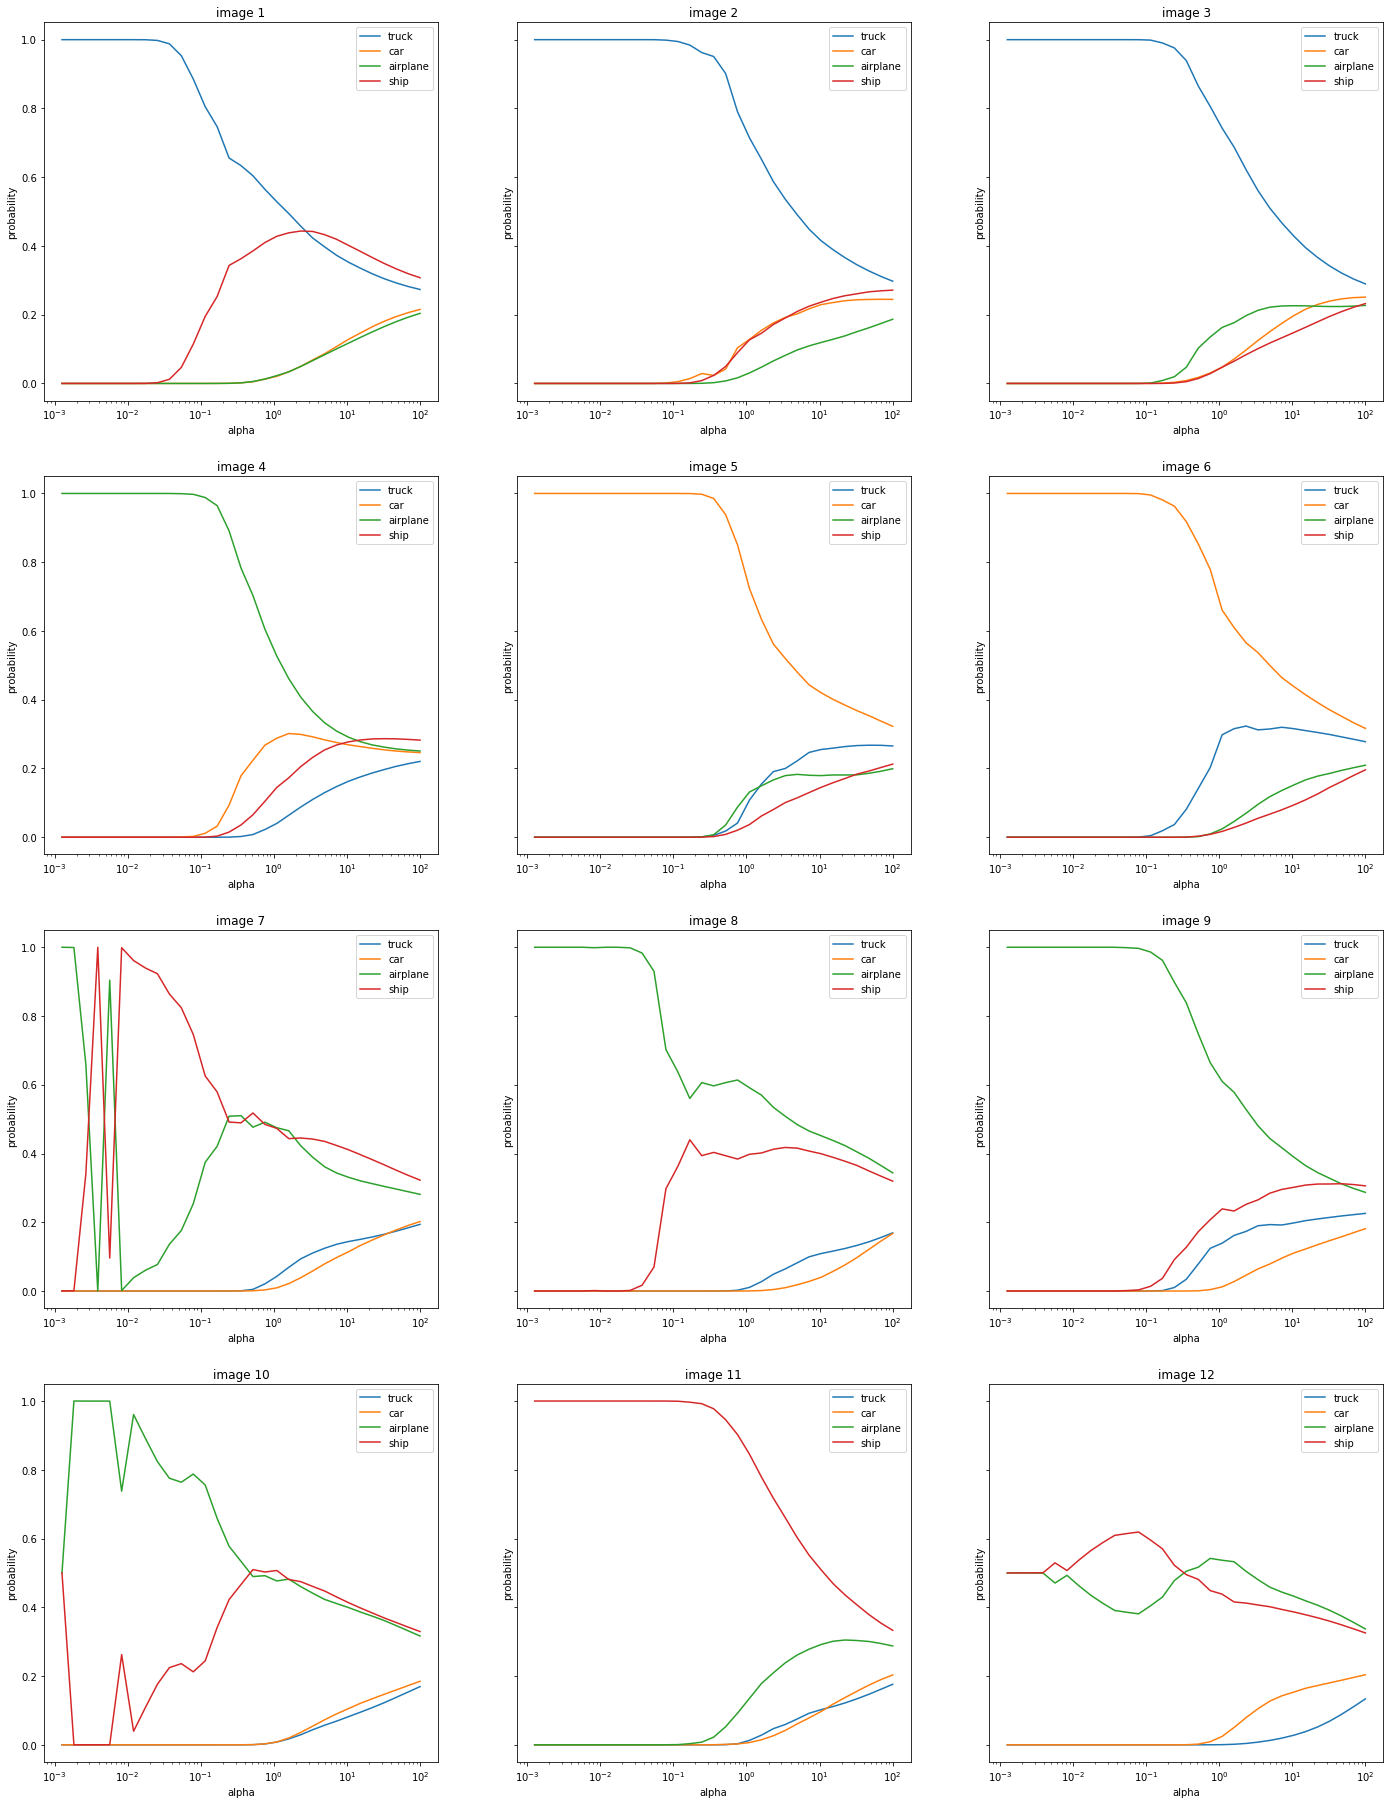

In [18]:
# For each test images, plot the class probability vs alpha curves
fig, axes = plt.subplots(nrows=4, ncols=3, sharey=True, figsize=(24, 32))
for i, ax in enumerate(axes.flatten()):
    img_probs = probs[:, i, :]
    
    for j in range(img_probs.shape[1]):
        ax.semilogx(alphas, img_probs[:, j], label=names[j])
        ax.set(
            title='image {}'.format(i+1),
            xlabel='alpha',
            ylabel='probability'
        )
        ax.legend()

As already said, the regularization strength alpha shrinks the coefficients towards 0. So, the logit values are decreasing and the logistic sigmoid values, i.e the probabilities, are pulled toward 50%. Remember that we have one classifier per class, so if each classifiers tend to return answer near 50% when alpha increases, it means that the normalized probabilities for each classes become 25%. So, it explains why all the curves seems to converge to 0.25.

When alpha is low (or too low), we can see that the probability are most of the time all 0% but one 100% for each images. It can be the truth for some of them because the classification is trivial in this case but it can also be a sign of overfitting.

Curves of images 2&3 shows ideal curves with easy and good classification. However, image 1 is interesting because as we can see, if the model isn't flexible enough (alpha too high), it would classify the truck as a ship. As soon as the alpha value is well tuned, there is no doubt anymore.

Image 4 is one beautiful misclassification example because never the model could have thought that it is a car, maybe a ship when high alpha but surely a plane... The fifty-fity hesitation from the image 12 is also interesting and the image 7 give a nice example of ovefitting (low bias/high variance) when alpha is low with the porbabilities switching between two classes with confidence near 0%/100%.